In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = ...
folder = "./Fashion10000/"

### Load Data and preprocess

In [4]:
X_vgg16 = np.load(folder+"Fashion10000_VGG_avg_all.npy")
X_vgg16.shape

(31077, 512)

In [5]:
Q_s = "Q4" #question selected
p_error = "0.5"

In [6]:
#Q3: cerca de 82-84.. valores varian 2% 

In [7]:
sets = np.loadtxt(folder+"sets_"+p_error+"_"+Q_s+".txt", dtype='U')
mask_train = sets == "train"
mask_test = sets == "test"

Z_data = np.loadtxt(folder+"Z_data_"+Q_s+".txt",dtype='int')
Z_train = Z_data[mask_train]
Z_test = Z_data[mask_test]

X_train_vgg16 = X_vgg16[mask_train]
X_test_vgg16 = X_vgg16[mask_test]

print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",X_test_vgg16.shape)
print("Label test shape:",Z_test.shape)

Input train shape: (25857, 512)
Label train shape: (25857,)
Input test shape: (1248, 512)
Label test shape: (1248,)


In [8]:
#created before..
mask_val = np.random.rand(Z_train.shape[0]) < 0.33

In [9]:
X_val_vgg16 = X_train_vgg16[mask_val]
X_train_vgg16 = X_train_vgg16[~mask_val]
Z_val = Z_train[mask_val]
Z_train = Z_train[~mask_val]

#X_train_vgg16, X_val_vgg16, Z_train, Z_val = train_test_split(X_train_vgg16, Z_train, test_size=0.33)
print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input val shape:",X_val_vgg16.shape)
print("Label val shape:",Z_val.shape)

Input train shape: (17363, 512)
Label train shape: (17363,)
Input val shape: (8494, 512)
Label val shape: (8494,)


In [10]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

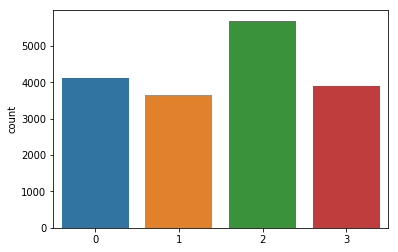

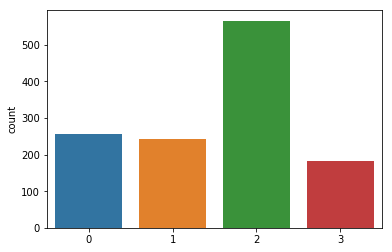

In [11]:
sns.countplot(Z_train)
plt.show()

sns.countplot(Z_test)
plt.show()

### Load annotations / Generate

In [12]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1
y_obs = y_obs[~mask_val] 
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 43 annotators that do not annotate on this set 
Shape (data,annotators):  (17363, 1346)
Classes:  4


In [ ]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [13]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.5135135 , 0.16216215, 0.13513513, 0.1891892 ],
        [0.06060606, 0.72727275, 0.12121212, 0.09090909],
        [0.        , 0.        , 0.88095236, 0.11904762],
        [0.        , 0.        , 0.625     , 0.375     ]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.68      , 0.28      , 0.        , 0.04      ],
        [0.        , 0.        , 0.6363636 , 0.36363637],
        [0.25      , 0.08333334, 0.08333334, 0.5833333 ]],

       [[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.6666667 , 0.33333334],
        [0.        , 0.        , 0.6666667 , 0.33333334]],

       ...,

       [[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [0.25      , 0.25      , 0.25      , 0.25      ]],

       [[0.        , 1.        , 0.        , 0.    

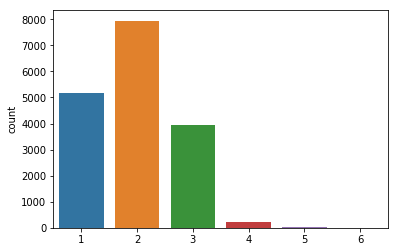

Minimum annotations in a example:  1
Maximum annotations in a example:  6
T data (expected value):  1.9566272018481086
Graphics of T weights


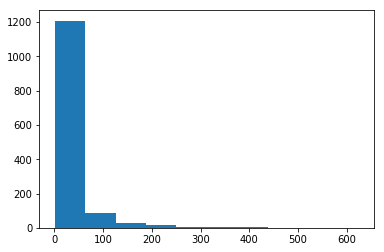

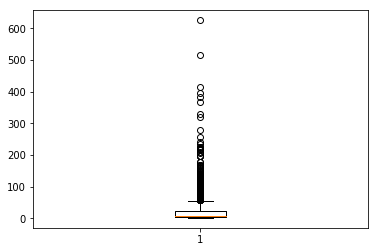

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  625
Mean annotations by an annotator:  25.076980014803848


In [70]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [14]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [76]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) 

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_val_pred = model_UB.predict_classes(Xstd_val)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 5


In [72]:
Kl = Z_train.max()+1
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_val_onehot = keras.utils.to_categorical(Z_val, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

In [73]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 516       
_________________________________________________________________
activation_9 (Activation)    (None, 4)                 0         
Total para

In [90]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 516       
_________________________________________________________________
activation_13 (Activation)   (None, 4)                 0         
Total params: 66,692
Trainable params: 66,436
Non-trainable params: 256
_________________________________________________________________
Trai

In [75]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

In [87]:
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 4


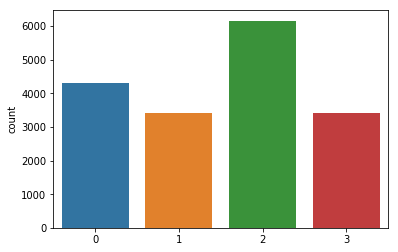

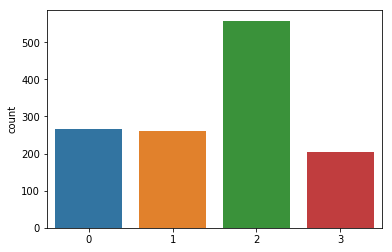

In [91]:
sns.countplot(Z_train_pred)
plt.show()
sns.countplot(Z_test_pred)
plt.show()

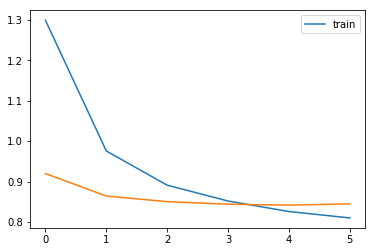

In [92]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [33]:
from code.evaluation import Evaluation_metrics

N = Xstd_train.shape[0]
evaluate = Evaluation_metrics(model_UB,'keras',N)
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8238,0.8238,0.8109


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.843,0.843,0.825


### Infer Labels (without predictive model)

In [79]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.754232 sec
Representation for DS in 0.578112 sec
Estimation MV in 0.001040 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -34875.36960012488
2 	 -33797.96251874367 	0.0193	0.305034	0.030893
3 	 -33451.381532317304 	0.0131	0.071528	0.010254
4 	 -33256.66848447198 	0.0078	0.066143	0.005821
5 	 -33132.509977173235 	0.0050	0.063487	0.003733
6 	 -33047.71422557834 	0.0046	0.060051	0.002559
7 	 -32986.88016410955 	0.0044	347.021271	0.001841
8 	 -32941.447285139635 	0.0042	0.052233	0.001377
9 	 -32906.56945848786 	0.0039	0.048752	0.001059
10 	 -32879.14200719682 	0.0037	0.045450	0.000833
11 	 -32857.20622208775 	0.0034	0.042328	0.000667
12 	 -32839.62964322639 	0.0031	0.039510	0.000535
13 	 -32825.47708083321 	0.0029	0.036761	0.000431
14 	 -32813.862151244255 	0.0027	0.034040	0.000354
15 	 -32804.06698408639 	0.0024	0.031303	0.000299
16 	 -32795.70814715521 	0.0023	346.994019	0.000255
17 	 -32788.388562598404 	0.0021	0.026505	0.000223
Class marginals
[0.24 0

In [80]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("F1 MV  on train:",f1_score(Z_train,mv_onehot.argmax(axis=1),average="macro"))

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))
print("F1 D&S  on train:",f1_score(Z_train,ds_labels.argmax(axis=1),average="macro"))

ACC MV on train: 0.6907305804215997
F1 MV  on train: 0.6716221774710519
ACC D&S on train: 0.6335547213398787
F1 D&S  on train: 0.6186611929516127


In [81]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_val_pred = model_mvsoft.predict_classes(Xstd_val)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 4


In [83]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_val_pred = model_mvhard.predict_classes(Xstd_val)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 5


In [85]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_val_pred = model_ds.predict_classes(Xstd_val)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 4


### Raykar Model (joint predict model)

In [91]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (11486, 1173, 3)


In [92]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=True,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (1173, 3, 3)
Q estimate shape:  (11486, 3)
Iter 1/50 
M step: done,  E step: done //  (in 6.83 sec)	logL: -9620.629	
Iter 2/50 
M step: done,  E step: done //  (in 1.15 sec)	logL: -9263.798	Tol1: 0.03709	Tol2: 0.13045	
Iter 3/50 
M step: done,  E step: done //  (in 1.14 sec)	logL: -9041.914	Tol1: 0.02395	Tol2: 0.03546	
Iter 4/50 
M step: done,  E step: done //  (in 1.13 sec)	logL: -8833.424	Tol1: 0.02306	Tol2: 0.01821	
Finished training
Initializing new EM...
Betas shape:  (1173, 3, 3)
Q estimate shape:  (11486, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.52 sec)	logL: -9626.348	
Iter 2/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -9135.764	Tol1: 0.05096	Tol2: 0.12893	
Iter 3/50 
M step: done,  E step: done //  (in 1.06 sec)	logL: -8969.268	Tol1: 0.01822	Tol2: 0.03307	
Iter 4/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -8848.744	Tol1: 0.01344	Tol2: 0.01833	
Finished training
Init

M step: done,  E step: done //  (in 2.52 sec)	logL: -9609.291	
Iter 2/50 
M step: done,  E step: done //  (in 1.06 sec)	logL: -9092.426	Tol1: 0.05379	Tol2: 0.12994	
Iter 3/50 
M step: done,  E step: done //  (in 1.08 sec)	logL: -8921.285	Tol1: 0.01882	Tol2: 0.03444	
Iter 4/50 
M step: done,  E step: done //  (in 1.08 sec)	logL: -8779.813	Tol1: 0.01586	Tol2: 0.01817	
Finished training
Initializing new EM...
Betas shape:  (1173, 3, 3)
Q estimate shape:  (11486, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.50 sec)	logL: -9612.503	
Iter 2/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -9217.396	Tol1: 0.04110	Tol2: 0.13253	
Iter 3/50 
M step: done,  E step: done //  (in 1.08 sec)	logL: -8947.873	Tol1: 0.02924	Tol2: 0.03582	
Iter 4/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -8793.646	Tol1: 0.01724	Tol2: 0.01893	
Finished training
Initializing new EM...
Betas shape:  (1173, 3, 3)
Q estimate shape:  (11486, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.54 sec

In [98]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_val_pred = raykarMC.get_predictions(Xstd_val).argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

### Our Proposed

In [15]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [16]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 0 1 1]
 [1 2 0 0]
 [0 0 2 1]
 ...
 [1 0 0 1]
 [0 1 0 0]
 [2 0 0 0]]
shape: (17363, 4)


Normalized entropy (0-1) of repeats annotations: 0.2558561957295823


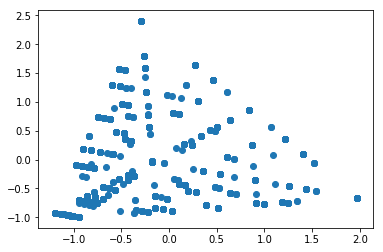

In [17]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.041659 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (17363, 4)
Betas:  (5, 4, 4)
Q estimate:  (17363, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 1.06 sec)	logL: -67392.492	
Finished training!


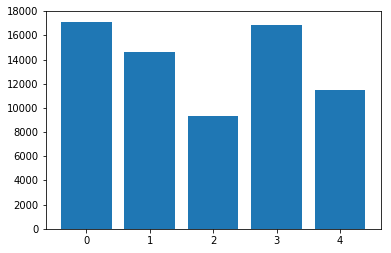

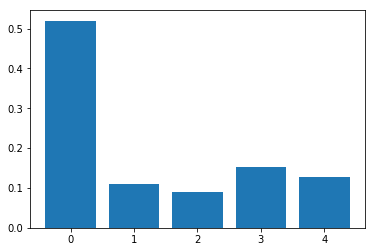

In [21]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())
plt.show()

In [20]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

459


NameError: name 'logL_Mchange' is not defined

1, 2 o 3...

In [22]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [46]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.042834 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (17363, 4)
Betas:  (3, 4, 4)
Q estimate:  (17363, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 2.70 sec)	logL: -37012.846	
Iter 2/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -35725.662	Tol1: 0.03478	Tol2: 0.28192	Tol3: 0.04649	
Iter 3/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -35213.923	Tol1: 0.01432	Tol2: 0.17259	Tol3: 0.01718	
Iter 4/50
M step: done,  E step: done //  (in 1.04 sec)	logL: -34908.222	Tol1: 0.00868	Tol2: 0.12434	Tol3: 0.00878	
Iter 5/50
M step: done,  E step: done //  (in 1.01 sec)	logL: -34682.409	Tol1: 0.00647	Tol2: 0.10822	Tol3: 0.00197	
Iter 6/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -34369.460	Tol1: 0.00902	Tol2: 0.08851	Tol3: 0.00704	
Iter 7/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -34231.242	Tol1: 0.00402	Tol2: 0.06899	Tol3: 0.0060

M step: done,  E step: done //  (in 1.02 sec)	logL: -33198.446	Tol1: 0.00760	Tol2: 0.04332	Tol3: 0.00886	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.042497 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (17363, 4)
Betas:  (3, 4, 4)
Q estimate:  (17363, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 2.34 sec)	logL: -36967.598	
Iter 2/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -35642.216	Tol1: 0.03585	Tol2: 0.27766	Tol3: 0.07463	
Iter 3/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -35202.201	Tol1: 0.01235	Tol2: 0.18444	Tol3: 0.01396	
Iter 4/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -34912.720	Tol1: 0.00822	Tol2: 0.13590	Tol3: 0.00890	
Iter 5/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -34689.353	Tol1: 0.00640	Tol2: 0.09120	Tol3: 0.00411	
Iter 6/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -34438.337	Tol1: 0.00724	Tol2: 0.09371	Tol3: 0.01113	
Iter 7/50
M step: done,  E s

M step: done,  E step: done //  (in 1.03 sec)	logL: -32846.612	Tol1: 0.00874	Tol2: 0.05574	Tol3: 0.00864	
Iter 14/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -32681.049	Tol1: 0.00504	Tol2: 0.04725	Tol3: 0.01255	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.043659 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (17363, 4)
Betas:  (3, 4, 4)
Q estimate:  (17363, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 2.34 sec)	logL: -36705.431	
Iter 2/50
M step: done,  E step: done //  (in 1.01 sec)	logL: -35590.391	Tol1: 0.03038	Tol2: 0.28040	Tol3: 0.04565	
Iter 3/50
M step: done,  E step: done //  (in 1.01 sec)	logL: -35186.734	Tol1: 0.01134	Tol2: 0.16967	Tol3: 0.00587	
Iter 4/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -34925.101	Tol1: 0.00744	Tol2: 0.13750	Tol3: 0.01156	
Iter 5/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -34642.251	Tol1: 0.00810	Tol2: 0.11808	Tol3: 0.01869	
Iter 6/50
M step: done,  E 

M step: done,  E step: done //  (in 1.02 sec)	logL: -34639.490	Tol1: 0.00704	Tol2: 0.10223	Tol3: 0.00999	
Iter 6/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -34334.293	Tol1: 0.00881	Tol2: 0.07498	Tol3: 0.00398	
Iter 7/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -34141.944	Tol1: 0.00560	Tol2: 0.07152	Tol3: 0.00824	
Iter 8/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -33951.363	Tol1: 0.00558	Tol2: 0.06900	Tol3: 0.00715	
Iter 9/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -33779.545	Tol1: 0.00506	Tol2: 0.06729	Tol3: 0.01191	
Iter 10/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -33525.314	Tol1: 0.00753	Tol2: 0.07014	Tol3: 0.00880	
Iter 11/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -33261.279	Tol1: 0.00788	Tol2: 0.05301	Tol3: 0.01240	
Iter 12/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -32990.040	Tol1: 0.00815	Tol2: 0.08086	Tol3: 0.01471	
Iter 13/50
M step: done,  E step: done //  (in 1.02 sec)	logL: -32831.224	Tol1:

In [47]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Global.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

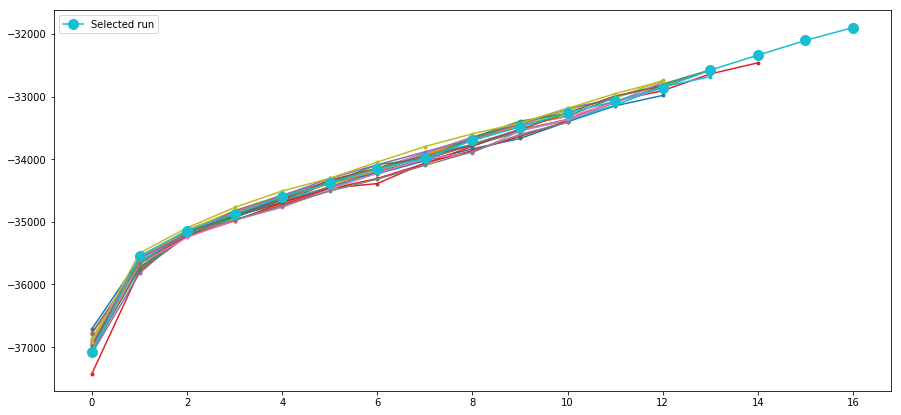

In [48]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [38]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (1346, 1346)


shape of annotator representation (T, R_t)= (1346, 16)


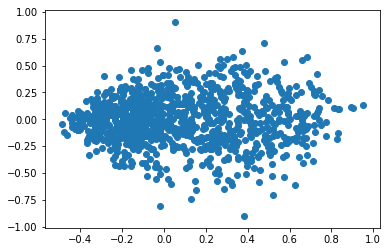

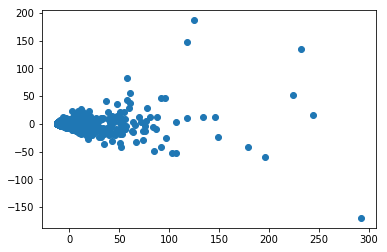

array([[21., 30., 66., 27.],
       [39.,  8.,  8., 12.],
       [ 1.,  3.,  4.,  2.],
       ...,
       [ 0.,  2.,  0.,  0.],
       [ 0.,  2.,  1.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [39]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [40]:
#different M_seted??
M_seted = 3

In [41]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=True,drop=0.5)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.003719 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (17363, 4)
Betas:  (3, 4, 4)
Q estimate:  (34067, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 5.77 sec)	logL: -36001.926	
Iter 2/50
M step: done,  E step: done //  (in 2.31 sec)	logL: -34275.226	Tol1: 0.04796	Tol2: 0.24328	
Iter 3/50
M step: done,  E step: done //  (in 2.27 sec)	logL: -33452.544	Tol1: 0.02400	Tol2: 0.20057	
Iter 4/50
M step: done,  E step: done //  (in 2.29 sec)	logL: -32691.081	Tol1: 0.02276	Tol2: 0.17719	
Iter 5/50
M step: done,  E step: done //  (in 2.28 sec)	logL: -32171.596	Tol1: 0.01589	Tol2: 0.15758	
Iter 6/50
M step: done,  E step: done //  (in 2.20 sec)	logL: -31623.424	Tol1: 0.01704	Tol2: 0.13942	
Iter 7/50
M step: done,  E step: done //  (in 2.30 sec)	logL: -31118.778	Tol1: 0.01596	Tol2: 0.14392	
Iter

KeyboardInterrupt: 

In [29]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind1.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

NameError: name 'gMixture_Ind1' is not defined

In [30]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=True,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [42]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000222 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (17363, 4)
Betas:  (3, 4, 4)
Q estimate:  (34067, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 4.49 sec)	logL: -36335.335	
Iter 2/50
M step: done,  E step: done //  (in 2.14 sec)	logL: -34518.826	Tol1: 0.04999	Tol2: 0.33779	
Iter 3/50
M step: done,  E step: done //  (in 2.15 sec)	logL: -33755.252	Tol1: 0.02212	Tol2: 0.25170	
Iter 4/50
M step: done,  E step: done //  (in 2.14 sec)	logL: -33184.764	Tol1: 0.01690	Tol2: 0.21064	
Iter 5/50
M step: done,  E step: done //  (in 2.15 sec)	logL: -32683.362	Tol1: 0.01511	Tol2: 0.19462	
Iter 6/50
M step: done,  E step: done //  (in 2.14 sec)	logL: -32290.278	Tol1: 0.01203	Tol2: 0.16352	
Iter 7/50
M step: done,  E step: done //  (in 2.15 sec)	logL: -31853.893	Tol1: 0.01351	Tol2: 0.16095	
Iter 8/50

KeyboardInterrupt: 

In [32]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind1.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

NameError: name 'gMixture_Ind3' is not defined

### Compare trained models

In [33]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [78]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.693,0.693,0.6806


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6418,0.6418,0.6283


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


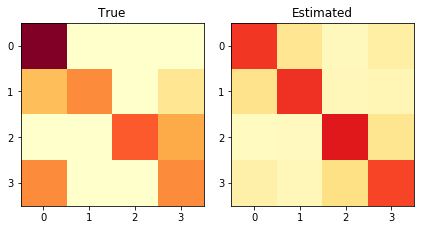

JS divergence: 0.1418	Norm Frobenius: 0.1807


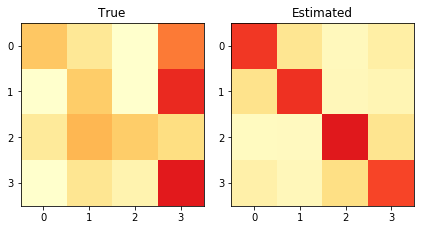

JS divergence: 0.2252	Norm Frobenius: 0.2881


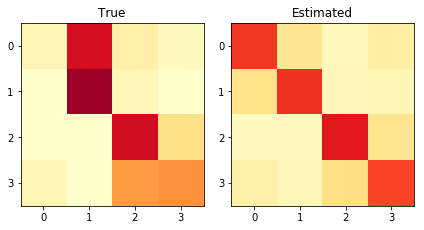

JS divergence: 0.1612	Norm Frobenius: 0.2474


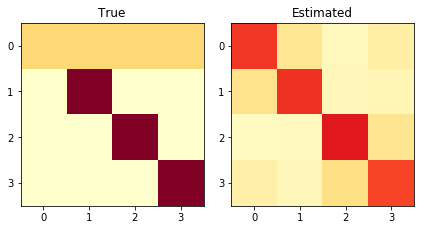

JS divergence: 0.1672	Norm Frobenius: 0.2029


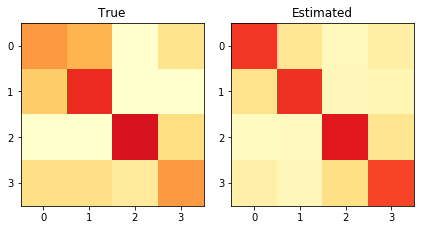

JS divergence: 0.0592	Norm Frobenius: 0.1087


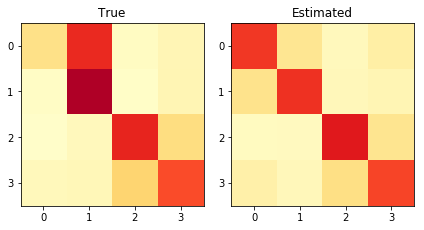

JS divergence: 0.0823	Norm Frobenius: 0.1959


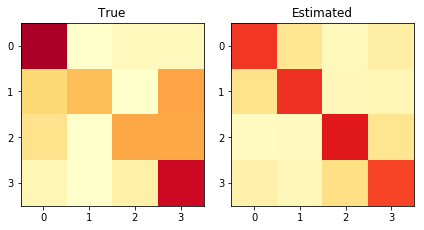

JS divergence: 0.1162	Norm Frobenius: 0.1926


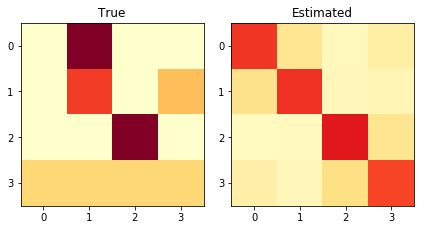

JS divergence: 0.2796	Norm Frobenius: 0.3149


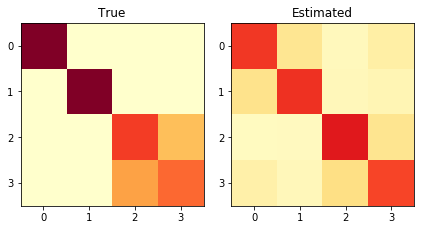

JS divergence: 0.1301	Norm Frobenius: 0.1558


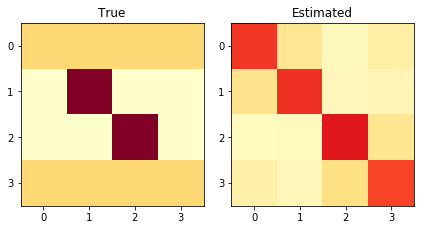

JS divergence: 0.1512	Norm Frobenius: 0.2089


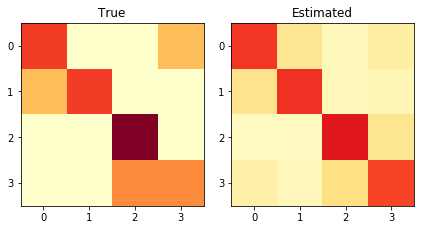

JS divergence: 0.1214	Norm Frobenius: 0.1418


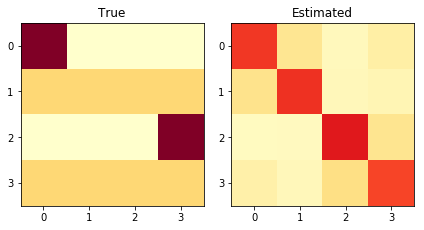

JS divergence: 0.2855	Norm Frobenius: 0.3443


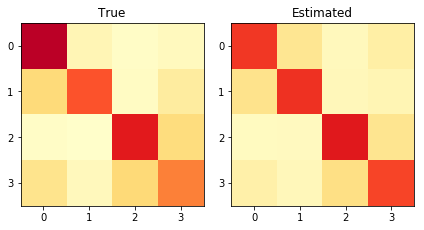

JS divergence: 0.0208	Norm Frobenius: 0.0768


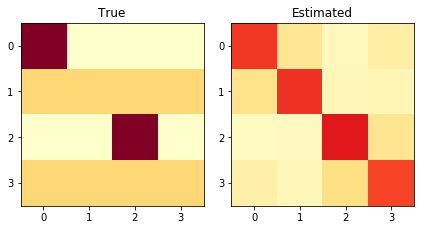

JS divergence: 0.1577	Norm Frobenius: 0.2136


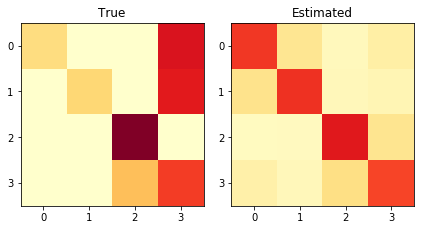

JS divergence: 0.2632	Norm Frobenius: 0.3061
Calculate confusion matrix on global version


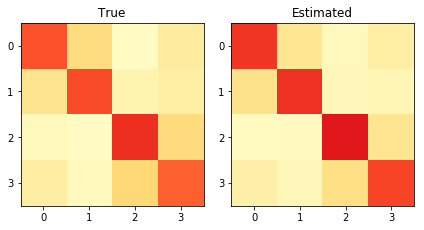

JS divergence: 0.0057	Norm Frobenius: 0.0412
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6446,0.6446,0.6232,0.2642,0.219,0.2015,0.1482,0.0412,0.0057


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6258,0.6258,0.603


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7653,0.7653,0.7264


In [82]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


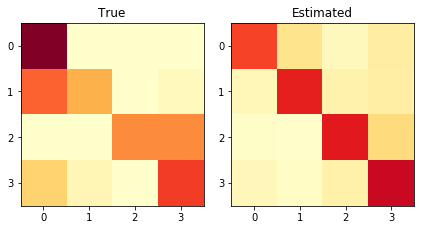

JS divergence: 0.1672	Norm Frobenius: 0.2255


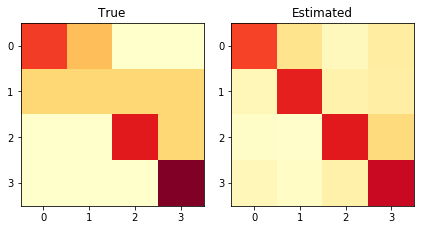

JS divergence: 0.0957	Norm Frobenius: 0.1579


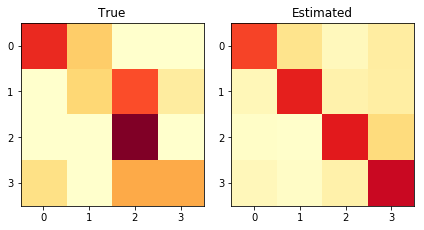

JS divergence: 0.1711	Norm Frobenius: 0.2472


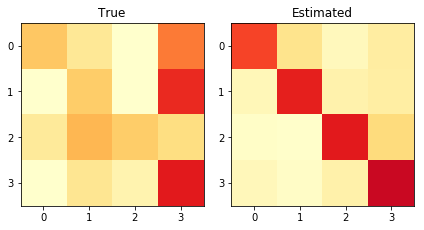

JS divergence: 0.2137	Norm Frobenius: 0.2802


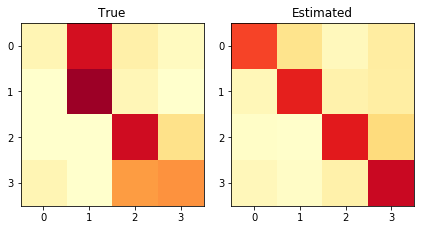

JS divergence: 0.1555	Norm Frobenius: 0.2560


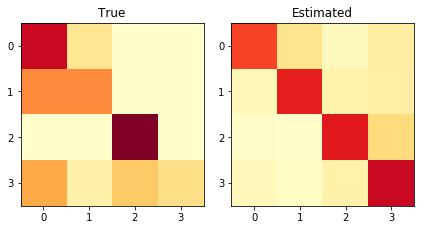

JS divergence: 0.2039	Norm Frobenius: 0.2513


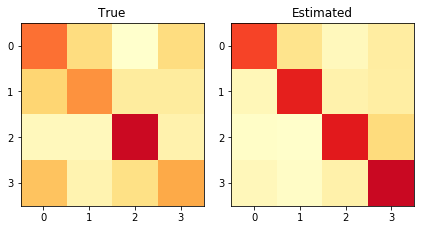

JS divergence: 0.0783	Norm Frobenius: 0.1642


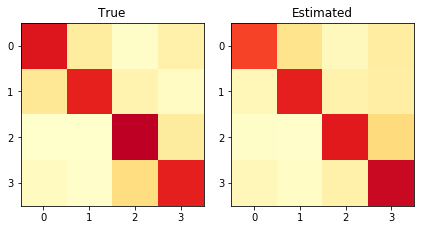

JS divergence: 0.0238	Norm Frobenius: 0.0725


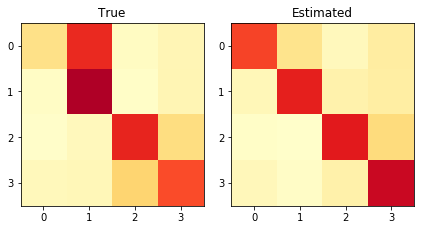

JS divergence: 0.0811	Norm Frobenius: 0.1940


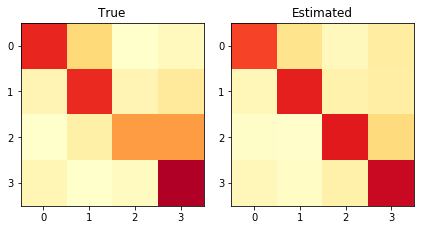

JS divergence: 0.0417	Norm Frobenius: 0.1050


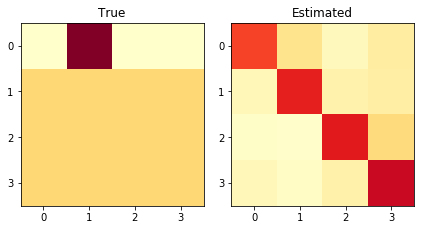

JS divergence: 0.3493	Norm Frobenius: 0.3752


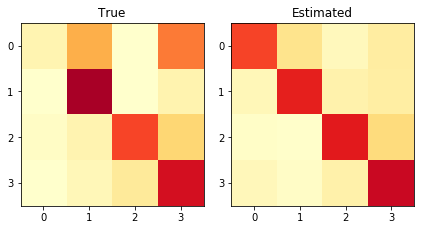

JS divergence: 0.1221	Norm Frobenius: 0.1956


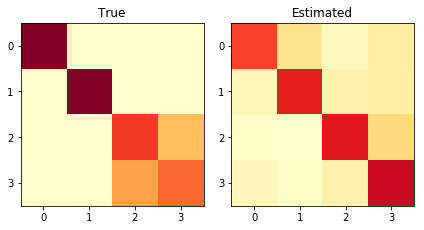

JS divergence: 0.1256	Norm Frobenius: 0.1710


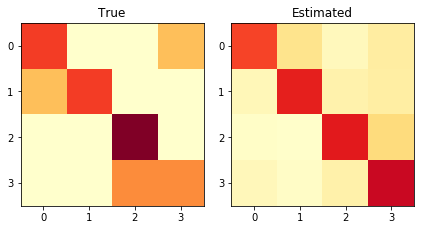

JS divergence: 0.1606	Norm Frobenius: 0.1896


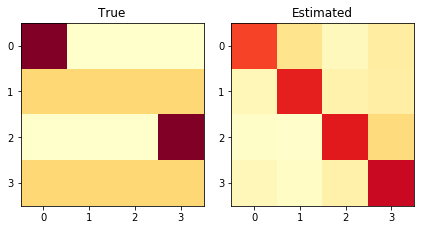

JS divergence: 0.3100	Norm Frobenius: 0.3626
Calculate confusion matrix on global version


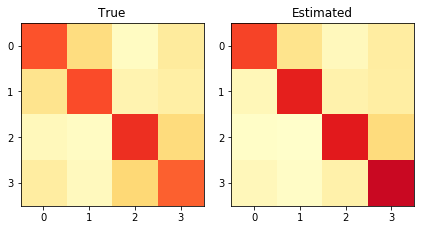

JS divergence: 0.0243	Norm Frobenius: 0.0879
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6202,0.6202,0.5325,0.2777,0.2316,0.2177,0.1602,0.0879,0.0243


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6025,0.6025,0.5144


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7187,0.7187,0.5967


In [84]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


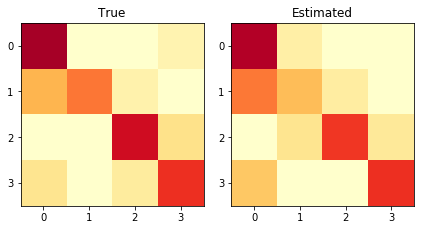

JS divergence: 0.0739	Norm Frobenius: 0.1047


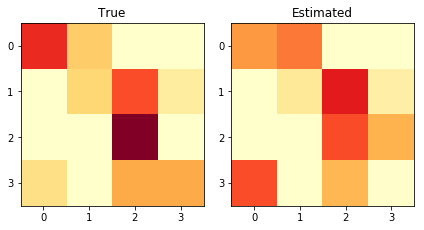

JS divergence: 0.1335	Norm Frobenius: 0.2187


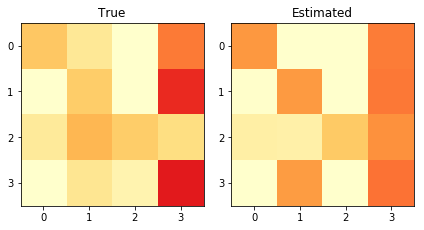

JS divergence: 0.0741	Norm Frobenius: 0.1520


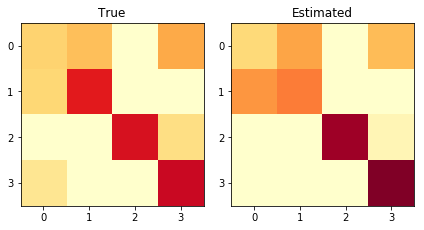

JS divergence: 0.0416	Norm Frobenius: 0.1129


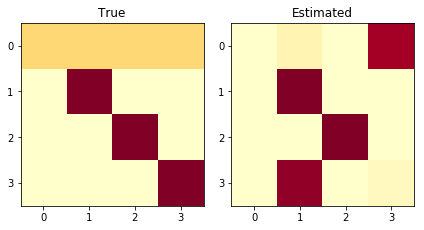

JS divergence: 0.3303	Norm Frobenius: 0.3928


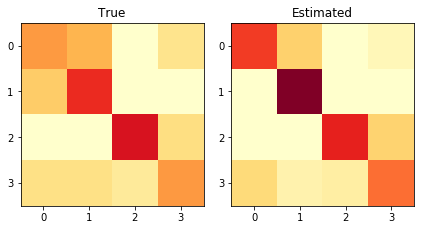

JS divergence: 0.0582	Norm Frobenius: 0.1300


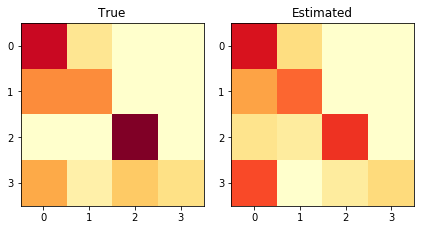

JS divergence: 0.0696	Norm Frobenius: 0.1271


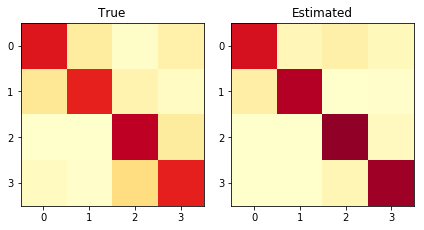

JS divergence: 0.0447	Norm Frobenius: 0.0903


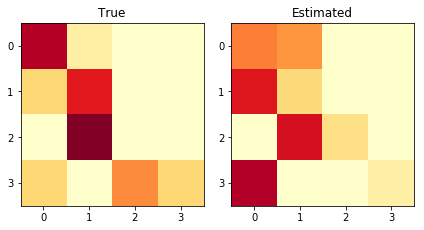

JS divergence: 0.2048	Norm Frobenius: 0.3108


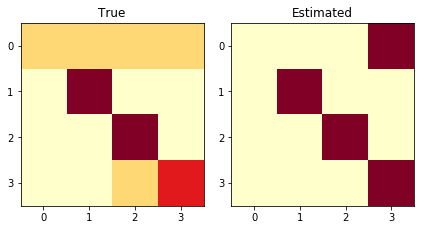

JS divergence: 0.1698	Norm Frobenius: 0.2336


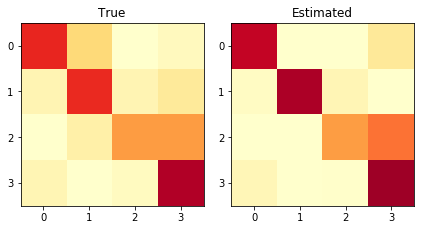

JS divergence: 0.0718	Norm Frobenius: 0.1032


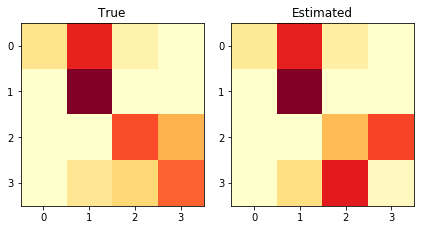

JS divergence: 0.0903	Norm Frobenius: 0.2097


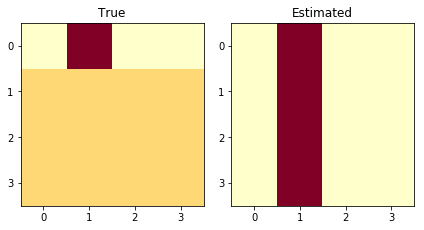

JS divergence: 0.4116	Norm Frobenius: 0.3750


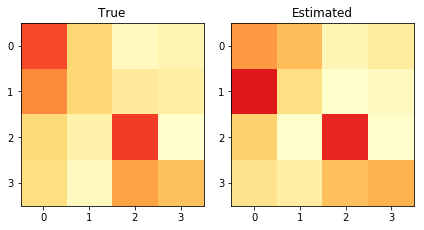

JS divergence: 0.0498	Norm Frobenius: 0.1022


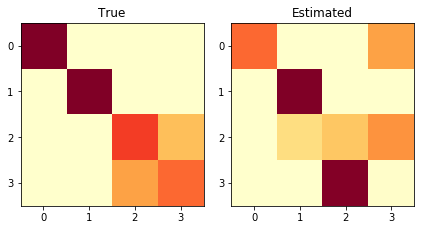

JS divergence: 0.1899	Norm Frobenius: 0.2730
Calculate confusion matrix on global version


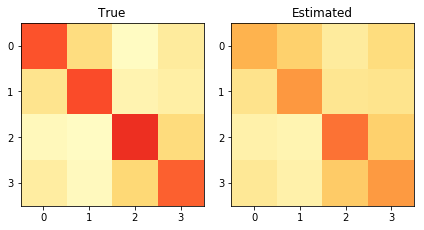

JS divergence: 0.0318	Norm Frobenius: 0.1051
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.636,0.636,0.5879,0.2543,0.2207,0.1402,0.0883,0.1051,0.0318


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6177,0.6177,0.569


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7498,0.7498,0.68


In [86]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
#prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


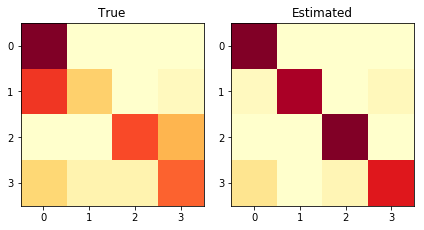

JS divergence: 0.1605	Norm Frobenius: 0.2644
Groups probabilities:  [0. 1. 0.]


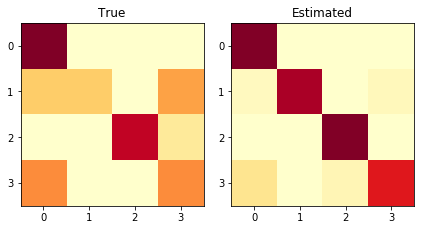

JS divergence: 0.1288	Norm Frobenius: 0.2261
Groups probabilities:  [0. 1. 0.]


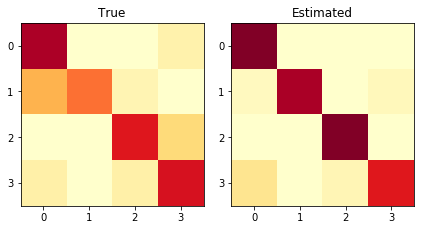

JS divergence: 0.0939	Norm Frobenius: 0.1540
Groups probabilities:  [0. 1. 0.]


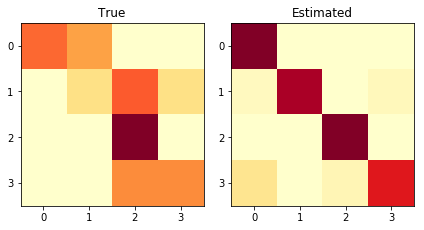

JS divergence: 0.2530	Norm Frobenius: 0.3098
Groups probabilities:  [2.000e-04 9.998e-01 0.000e+00]


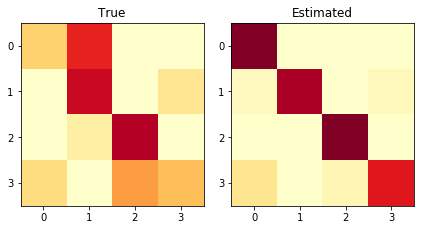

JS divergence: 0.1974	Norm Frobenius: 0.2975
Groups probabilities:  [0.0026 0.9974 0.    ]


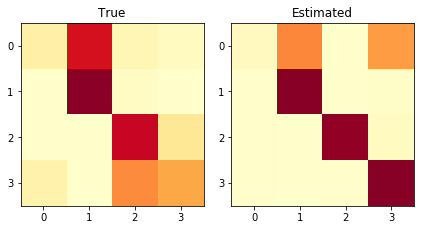

JS divergence: 0.1539	Norm Frobenius: 0.2329
Groups probabilities:  [1. 0. 0.]


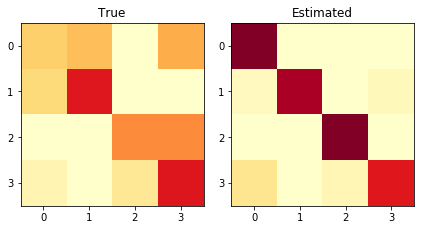

JS divergence: 0.2294	Norm Frobenius: 0.2902
Groups probabilities:  [0. 1. 0.]


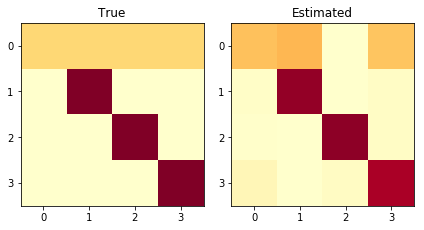

JS divergence: 0.0531	Norm Frobenius: 0.0786
Groups probabilities:  [0.6968 0.3032 0.    ]


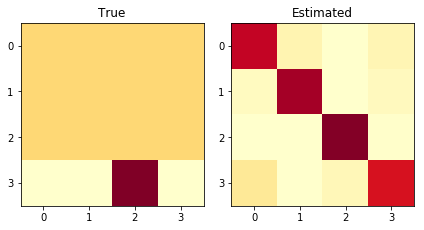

JS divergence: 0.5166	Norm Frobenius: 0.4585
Groups probabilities:  [1.464e-01 8.535e-01 1.000e-04]


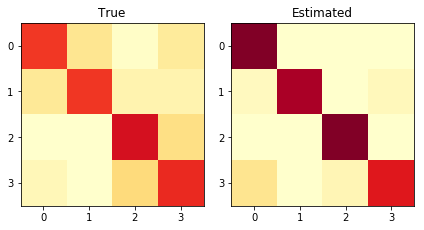

JS divergence: 0.1016	Norm Frobenius: 0.1470
Groups probabilities:  [0. 1. 0.]


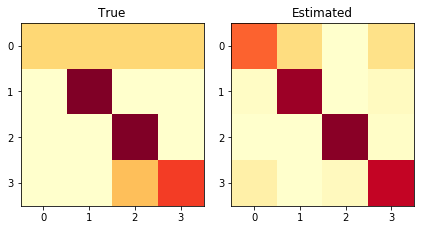

JS divergence: 0.0925	Norm Frobenius: 0.1406
Groups probabilities:  [0.4276 0.5724 0.    ]


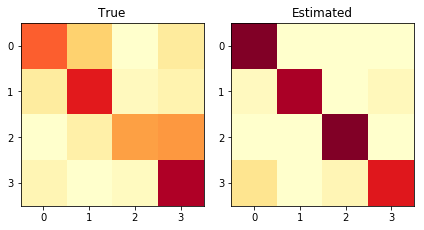

JS divergence: 0.1618	Norm Frobenius: 0.2315
Groups probabilities:  [0. 1. 0.]


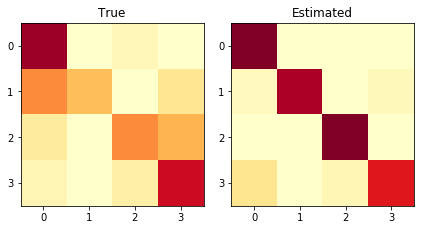

JS divergence: 0.1617	Norm Frobenius: 0.2478
Groups probabilities:  [0. 1. 0.]


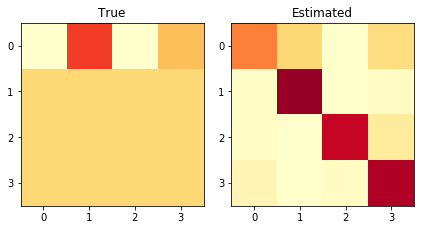

JS divergence: 0.3712	Norm Frobenius: 0.3677
Groups probabilities:  [0.4862 0.3768 0.1371]


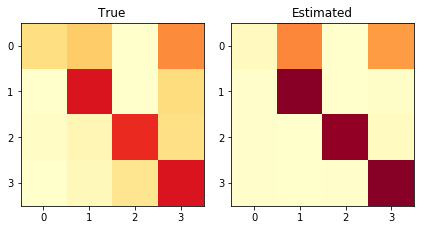

JS divergence: 0.0935	Norm Frobenius: 0.1461
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


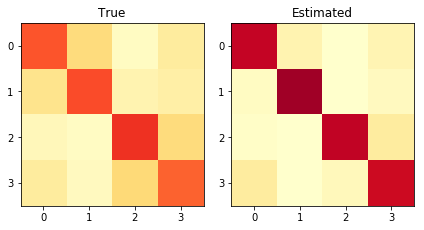

JS divergence: 0.0715	Norm Frobenius: 0.1466
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6742,0.6742,0.658,0.302,0.263,0.2481,0.1913,0.1466,0.0715


Val


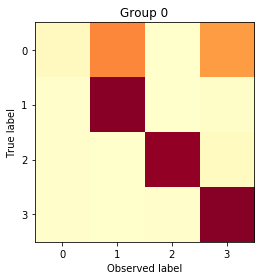

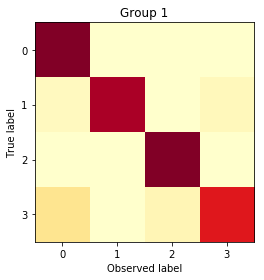

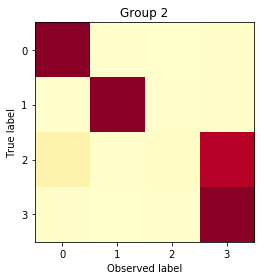

Inertia JS: 0.3034384716247916
Inertia NormF: 0.3565158646418873
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.1502,202,0.3179,0.7385,0.7676,0.6513,0.0685,1,0.3034,0.3565,0.5519,0.5519
1,1,0.7145,961,0.2844,0.9157,0.9545,0.8876,0.0540,0,0.3034,0.3565,0.6209,0.6209
2,2,0.1353,182,0.2066,0.7376,0.7586,0.6502,0.2111,3,0.3034,0.3565,0.4483,0.4483


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6286,0.6286,0.609


In [49]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs, y_o_groups=y_o_groups,# yo_pred=prob_Yxt,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [40]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [41]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [42]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [43]:
plot_alphas(gMixture_Ind1.alphas_training)

NameError: name 'plot_alphas' is not defined

In [44]:
plot_alphas(gMixture_Ind3.alphas_training)

NameError: name 'plot_alphas' is not defined

### project confusion matrices

In [45]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

NameError: name 'gMixture_Global' is not defined

NameError: name 'centroids_plot_G' is not defined

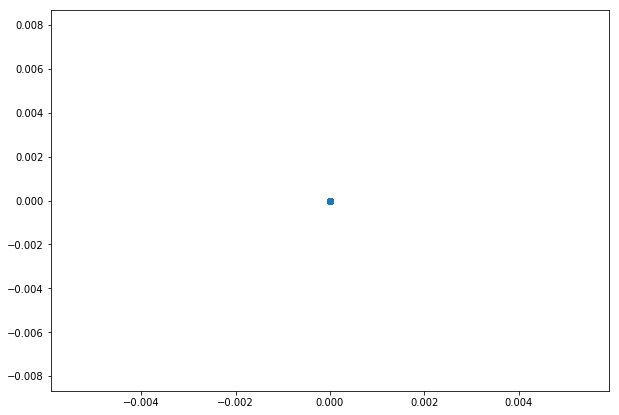

In [46]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo